# Titanic: Machine Learning from Disaster

# Data overview

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

# Goal
Predict if a passenger survived the sinking of the Titanic or not. 
For each PassengerId in the test set, you must predict a 0 or 1 value for the Survived variable.


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pd.set_option('display.width', 256)

# Explore the data

In [2]:
train_data = pd.read_csv("datasets/train.csv")
test_data = pd.read_csv("datasets/test.csv")

all_data = pd.concat([train_data, test_data], sort=False)

all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Survived by class and sex

In [3]:
train_data.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True)

Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64

Chance to survive as passenger of:
- First class: female - 96,8%, male - 36,8%
- Second class: female - 92,1%, male - 15,7%
- Third class: female - 50%, male - 13,5%

## Describe data for male/female

### Train set male

In [4]:
describe_fields = ["Age", "Fare", "Pclass", "SibSp", "Parch"]
train_data[train_data["Sex"] == "male"][describe_fields].describe()

,Age,Fare,Pclass,SibSp,Parch
count,453.000000,577.000000,577.000000,577.000000,577.000000
mean,30.726645,25.523893,2.389948,0.429809,0.235702
std,14.678201,43.138263,0.813580,1.061811,0.612294
min,0.420000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,2.000000,0.000000,0.000000
50%,29.000000,10.500000,3.000000,0.000000,0.000000
75%,39.000000,26.550000,3.000000,0.000000,0.000000
max,80.000000,512.329200,3.000000,8.000000,5.000000


### Train set female

In [5]:
train_data[train_data["Sex"] == "female"][describe_fields].describe()

,Age,Fare,Pclass,SibSp,Parch
count,261.000000,314.000000,314.000000,314.000000,314.000000
mean,27.915709,44.479818,2.159236,0.694268,0.649682
std,14.110146,57.997698,0.857290,1.156520,1.022846
min,0.750000,6.750000,1.000000,0.000000,0.000000
25%,18.000000,12.071875,1.000000,0.000000,0.000000
50%,27.000000,23.000000,2.000000,0.000000,0.000000
75%,37.000000,55.000000,3.000000,1.000000,1.000000
max,63.000000,512.329200,3.000000,8.000000,6.000000


### Test set male

In [6]:
test_data[test_data["Sex"] == "male"][describe_fields].describe()

,Age,Fare,Pclass,SibSp,Parch
count,205.000000,265.000000,266.000000,266.000000,266.000000
mean,30.272732,27.527877,2.334586,0.379699,0.274436
std,13.389528,41.079423,0.808497,0.843735,0.883745
min,0.330000,0.000000,1.000000,0.000000,0.000000
25%,22.000000,7.854200,2.000000,0.000000,0.000000
50%,27.000000,13.000000,3.000000,0.000000,0.000000
75%,40.000000,26.550000,3.000000,1.000000,0.000000
max,67.000000,262.375000,3.000000,8.000000,9.000000


### Test set female

In [7]:
test_data[test_data["Sex"] == "female"][describe_fields].describe()

,Age,Fare,Pclass,SibSp,Parch
count,127.000000,152.000000,152.000000,152.000000,152.000000
mean,30.272362,49.747699,2.144737,0.565789,0.598684
std,15.428613,73.108716,0.887051,0.974313,1.105434
min,0.170000,6.950000,1.000000,0.000000,0.000000
25%,20.500000,8.626050,1.000000,0.000000,0.000000
50%,27.000000,21.512500,2.000000,0.000000,0.000000
75%,38.500000,55.441700,3.000000,1.000000,1.000000
max,76.000000,512.329200,3.000000,8.000000,9.000000


I could find a difference between description of test and train male data sets. Look at the max Fare and max Age, or max Age in female data sets. Data is very different. So I should be careful with that features then I will build my model. Maybe I need to delete data spikes or take an median values for this features.

# Make Data Digest
To make data transformation: remove NaN, text to numbers and etc.

In [8]:
class DataDigest:

    def __init__(self):
        self.ages = None
        self.fares = None
        self.titles = None
        self.cabins = None
        self.families = None
        self.tickets = None

def get_title(name):
    if pd.isnull(name):
        return "Null"

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"


def get_family(row):
    last_name = row["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return f"{last_name.lower()}_{family_size}"
        else:
            return "nofamily"
    else:
        return "unknown"


data_digest = DataDigest()
data_digest.ages = all_data.groupby("Sex")["Age"].median() # median age by sex
data_digest.fares = all_data.groupby("Pclass")["Fare"].median() # median fare by class
data_digest.titles = pd.Index(test_data["Name"].apply(get_title).unique()) # titles
data_digest.families = pd.Index(test_data.apply(get_family, axis=1).unique()) # family ids
data_digest.cabins = pd.Index(test_data["Cabin"].fillna("unknown").unique()) # cabins ids
data_digest.tickets = pd.Index(test_data["Ticket"].fillna("unknown").unique()) # tickets ids

# Data transformations

In [9]:
def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1


def transform_data(data, digest):
    # Age - NaN to median age
    data["AgeF"] = data.apply(lambda r: digest.ages[r["Sex"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

    # Fare - NaN to median Fare by class
    data["FareF"] = data.apply(lambda r: digest.fares[r["Pclass"]] if pd.isnull(r["Fare"]) else r["Fare"], axis=1)

    # Gender - string to boolean values and dummies
    genders = {"male": 1, "female": 0}
    data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))
    gender_dummies = pd.get_dummies(data["Sex"], prefix="SexD", dummy_na=False)
    data = pd.concat([data, gender_dummies], axis=1)

    # Embarkment - string to int values and dummies
    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["EmbarkedF"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))
    embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedD", dummy_na=False)
    data = pd.concat([data, embarkment_dummies], axis=1)

    # Add relatives feature
    data["RelativesF"] = data["Parch"] + data["SibSp"]

    # Add single or not feature
    data["SingleF"] = data["RelativesF"].apply(lambda r: 1 if r == 0 else 0)

    # Deck - string to int values and dummies
    decks = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["DeckF"] = data["Cabin"].fillna("U").apply(lambda c: decks.get(c[0], -1))
    deck_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="DeckD", dummy_na=False)
    data = pd.concat([data, deck_dummies], axis=1)

    # Titles dummies
    title_dummies = pd.get_dummies(data["Name"].apply(lambda n: get_title(n)), prefix="TitleD", dummy_na=False)
    data = pd.concat([data, title_dummies], axis=1)
    
    data["CabinF"] = data["Cabin"].fillna("unknown").apply(lambda c: get_index(c, digest.cabins))
    data["TitleF"] = data["Name"].apply(lambda n: get_index(get_title(n), digest.titles))
    data["TicketF"] = data["Ticket"].apply(lambda t: get_index(t, digest.tickets))
    data["FamilyF"] = data.apply(lambda r: get_index(get_family(r), digest.families), axis=1)

    # Stats
    age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90]
    data["AgeR"] = pd.cut(data["Age"].fillna(-1), bins=age_bins).astype(object)

    return data

In [10]:
train_data_transformed = transform_data(train_data, data_digest)
test_data_transformed = transform_data(test_data, data_digest)
all_data_transformed = pd.concat([train_data_transformed, test_data_transformed], sort=False)

all_data_transformed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,TitleD_mrs,TitleD_ms,TitleD_rev,TitleD_sir,CabinF,TitleF,TicketF,FamilyF,AgeR,TitleD_dona
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0.0,0,0,-1,0,"(20, 25]",NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0.0,46,1,218,0,"(30, 40]",NaN
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0.0,0,2,-1,0,"(25, 30]",NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0.0,-1,1,-1,0,"(30, 40]",NaN
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0.0,0,0,-1,0,"(30, 40]",NaN


# More analysis
Let's check survive by age range column.

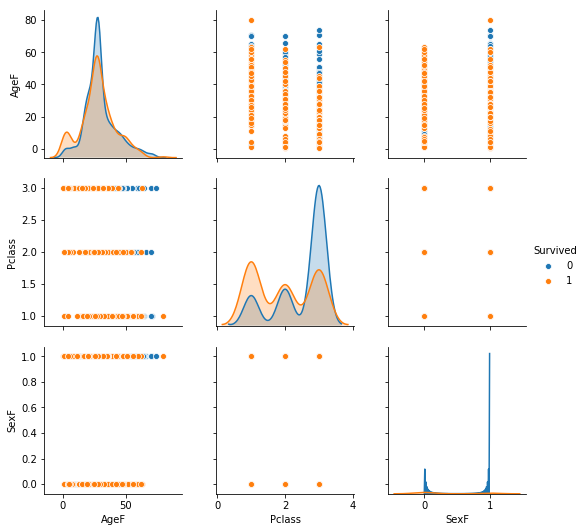

In [20]:
sns.pairplot(train_data_transformed, vars=["AgeF", "Pclass", "SexF"], hue="Survived", dropna=True)
plt.show()

I could see correlation between age and male gender: then man is elder, then he has less chance to survive. And where is no correlation between age and female gender.

# Features list

In [11]:
predictors = ["Pclass",
              "AgeF",
              "TitleF",
              "TitleD_mr", "TitleD_mrs", "TitleD_miss", "TitleD_master", "TitleD_ms", 
              "TitleD_col", "TitleD_rev", "TitleD_dr",
              "CabinF",
              "DeckF",
              "DeckD_U", "DeckD_A", "DeckD_B", "DeckD_C", "DeckD_D", "DeckD_E", "DeckD_F", "DeckD_G",
              "FamilyF",
              "TicketF",
              "SexF",
              "SexD_male", "SexD_female",
              "EmbarkedF",
              "EmbarkedD_S", "EmbarkedD_C", "EmbarkedD_Q",
              "FareF",
              "SibSp", "Parch",
              "RelativesF",
              "SingleF"]

# Scale data for different classifiers

In [13]:
scaler = StandardScaler()
scaler.fit(all_data_transformed[predictors])

train_data_scaled = scaler.transform(train_data_transformed[predictors])
test_data_scaled = scaler.transform(test_data_transformed[predictors])

C:\Users\d.vasilev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\d.vasilev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\d.vasilev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


# Classifications
Let's select cross-validation strategy.

In [41]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
scores = {}

## K-neighbors classifier

In [42]:
k_ngbh = KNeighborsClassifier(n_neighbors=3)
scores_all = cross_val_score(k_ngbh, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1)
scores["K-neighbors"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (k-neighbors): {scores_all.mean()}/{scores_all.std()}")

Accuracy (k-neighbors): 0.7946127946127947/0.02199317389704316


## SGD Classifier

In [43]:
sgd = SGDClassifier(random_state=1)
scores_all = cross_val_score(sgd, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1)
scores["SGD"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (sgd): {scores_all.mean()}/{scores_all.std()}")

Accuracy (sgd): 0.7384960718294051/0.04951008978700958


## SVC

In [44]:
svc = SVC(C=1.0)
scores_all = cross_val_score(svc, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1)
scores["SVC"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (svm): {scores_all.mean()}/{scores_all.std()}")

Accuracy (svm): 0.8260381593714926/0.011110544261068086


## GaussianNB

In [45]:
gnb = GaussianNB()
scores_all = cross_val_score(gnb, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1)
scores["GaussianNB"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (naive bayes): {scores_all.mean()}/{scores_all.std()}")

Accuracy (naive bayes): 0.7665544332211/0.018713054994986624


## Linear Regression

In [47]:
def linear_scorer(estimator, x, y):
    scorer_predictions = estimator.predict(x)

    scorer_predictions[scorer_predictions > 0.5] = 1
    scorer_predictions[scorer_predictions <= 0.5] = 0

    return metrics.accuracy_score(y, scorer_predictions)

lnr_reg = LinearRegression()
scores_all = cross_val_score(lnr_reg, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1,
                         scoring=linear_scorer)
scores["LinearRegression"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (linear regression): {scores_all.mean()}/{scores_all.std()}")

Accuracy (linear regression): 0.8249158249158249/0.009523323652344083


## Logistic Regression

In [48]:
log_reg = LogisticRegression(random_state=1)
scores_all = cross_val_score(log_reg, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1,
                         scoring=linear_scorer)
scores["LogisticRegression"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (logistic regression): {scores_all.mean()}/{scores_all.std()}")

Accuracy (logistic regression): 0.8237934904601572/0.012396589244879071


## Random Forest

In [49]:
rand_frst = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
scores_all = cross_val_score(rand_frst, train_data_scaled, train_data_transformed["Survived"], cv=skf, n_jobs=-1)
scores["RandomForest"] = {"mean": scores_all.mean(), "std": scores_all.std()}
print(f"Accuracy (random forest): {scores_all.mean()}/{scores_all.std()}")

Accuracy (random forest): 0.8294051627384961/0.0031744412174480106


In [60]:
means = []
stds = []
for value in scores.values():
    means.append(value["mean"])
    stds.append(value["std"])

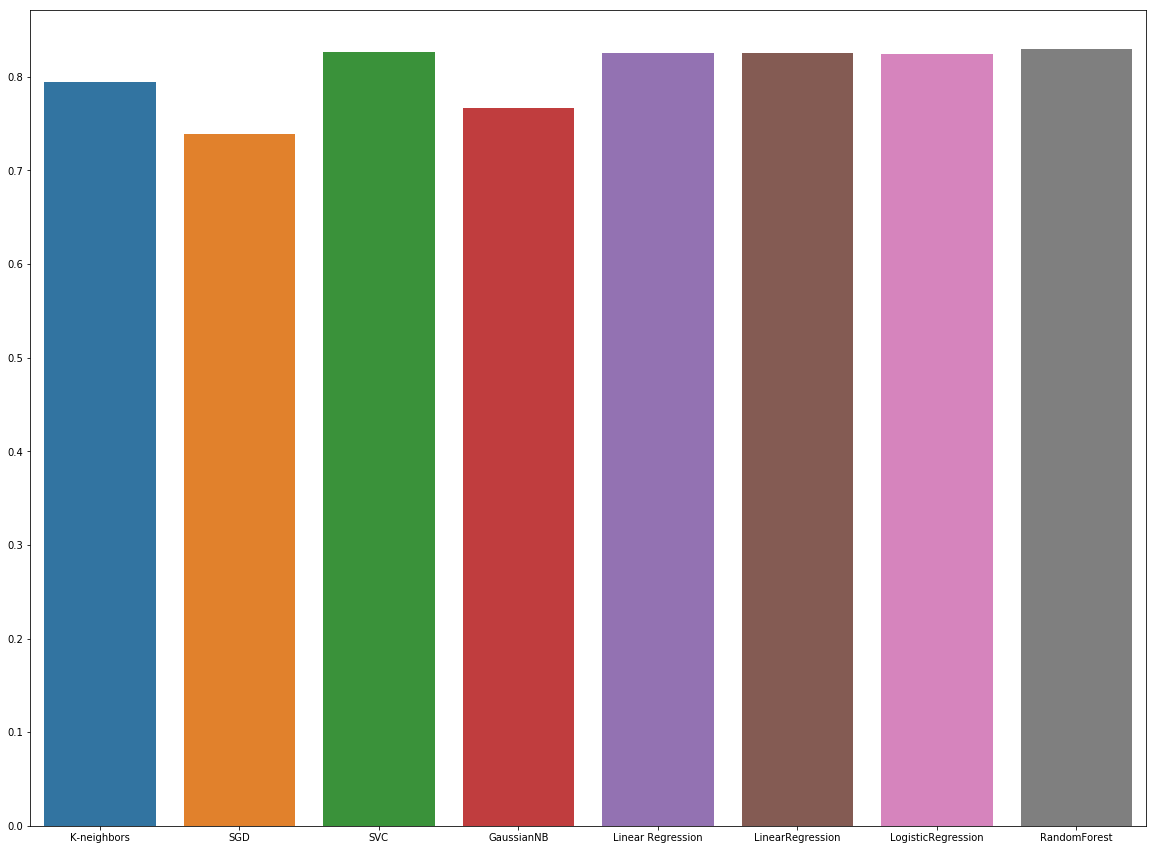

In [62]:
plt.subplots(figsize=(20,15))
sns.barplot(list(scores.keys()), means)
plt.show()

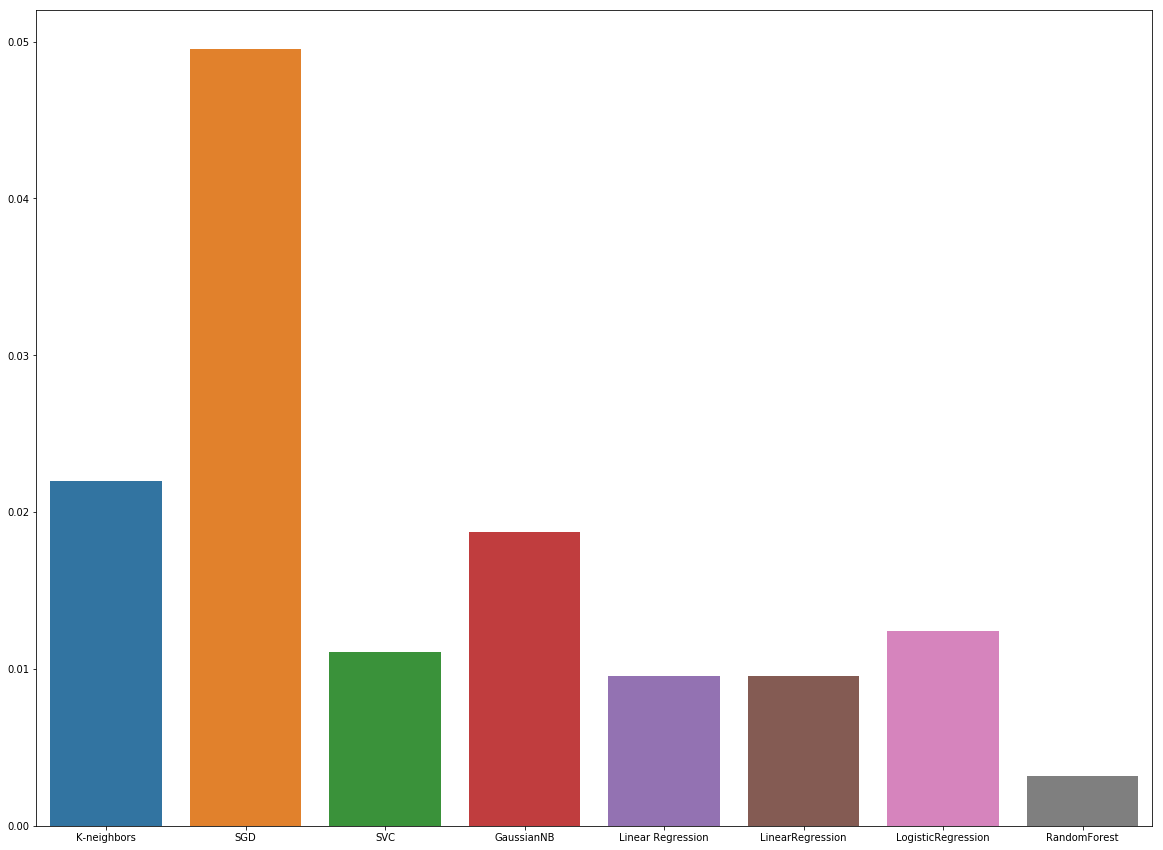

In [63]:
plt.subplots(figsize=(20,15))
sns.barplot(list(scores.keys()), stds)
plt.show()

As I could see RandomForest show me the best accuracy results, so I want to make some experiments with its options.

In [65]:
rand_frst_model = RandomForestClassifier(random_state=1)
rand_frst_params = [{
    "n_estimators": [350, 400, 450],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2, 4]
}]
rand_frst_grid = GridSearchCV(rand_frst_model, rand_frst_params, cv=skf, refit=True, verbose=1, n_jobs=-1)
rand_frst_grid.fit(train_data_scaled, train_data_transformed["Survived"])
rand_frst_best = rand_frst_grid.best_estimator_
print(f"Accuracy (random forest auto): {rand_frst_grid.best_score_} with params {rand_frst_grid.best_params_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   11.9s finished


Accuracy (random forest auto): 0.8383838383838383 with params {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 450}


# Make kaggle result

In [69]:
test = rand_frst_best

test.fit(train_data_scaled, train_data_transformed["Survived"])

predictions = test.predict(test_data_scaled)

submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions
})

submission.to_csv("titanic-submission.csv", index=False, sep=",")
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
